# Coastline compare.

This notebook tries to use sentinel one data to extract a time series of coastlines for a given aoi

In [1]:
# imports needed for the rest of the notebook.

import numpy as np
import collections
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
import scipy
import datacube
from shapely.geometry import MultiLineString, mapping
from skimage.measure import find_contours
from datacube.storage import masking
from matplotlib import cm


In [2]:
# Define area of interest
# Fiji
x = (178.281, 178.655)
y = (-17.91, -18.1732)
time = ("2018-04-02", "2019-03-30")

# How often to extract coast line polygons.
time_step = '2M'

In [41]:
# percentage of total of images in a time window that need to be water to include in the output.
threshold = 75 
min_vertices = 100
# water settings in sar
vv_threshold = 12
vh_threshold = -15.5

# tuneable parameters 
output_shp = f's1_land_water-{threshold}.shp' # output filename

In [7]:
# Do the query to get the data. This may take a while, depending on your aoi settings.
# query parameters
res = (-30,30)
crs = "EPSG:4326"

query=({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res,
        'time': time})

dc = datacube.Datacube(app="s1_coastline")

# load up the data and filter down to water
s1_coverage = dc.load(product="s1_gamma0_scene", output_crs ="EPSG:32760", **query)
s1_coverage = masking.mask_invalid_data(s1_coverage)
water = ((s1_coverage["vv"] <= vv_threshold) & (s1_coverage["vh"] <= vh_threshold))

In [49]:
# define save polygon function
def save_poly(output_geojson, crs, polygon):
    
    attribute_data = {} 
    attribute_dtypes = {} 
    schema = {'geometry': 'MultiLineString',
          'properties': attribute_dtypes}
    
    with fiona.open(output_geojson, 'w',
                crs={'init': str(crs), 'no_defs': True},
                driver='GeoJSON',
                schema=schema) as output:

        # Create multi-string object from all contour coordinates
        contour_multilinestring = MultiLineString(polygon)

        # Get attribute values for writing
        attribute_vals = {field_name: field_vals[i] for field_name, field_vals in 
                          attribute_data.items()}

        # Write output shapefile to file with z-value field
        output.write({'properties': attribute_vals,
                      'geometry': mapping(contour_multilinestring)})

In [6]:
def extract_contour(data_source, data, threshold, min_vertices):
    ds_affine = data_source.geobox.transform
    ps = ds_affine[0]  # Compute pixel size

    contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                    find_contours(data, threshold)]
    contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]
    contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]
    return contours_withdata

0 t: 3.75 m: 5
2018-04-30T00:00:00.000000000
1 t: 7.5 m: 10
2018-06-30T00:00:00.000000000
2 t: 6.75 m: 9
2018-08-31T00:00:00.000000000
3 t: 7.5 m: 10
2018-10-31T00:00:00.000000000
4 t: 7.5 m: 10
2018-12-31T00:00:00.000000000
5 t: 6.75 m: 9
2019-02-28T00:00:00.000000000
6 t: 3.75 m: 5
2019-04-30T00:00:00.000000000


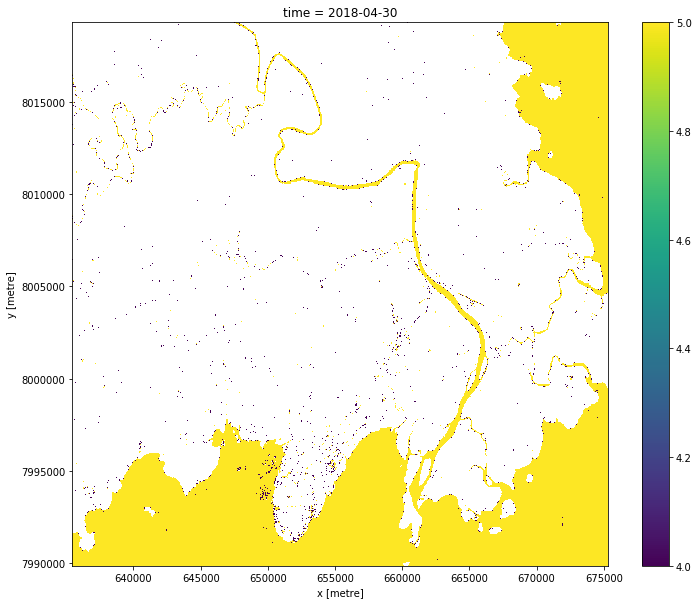

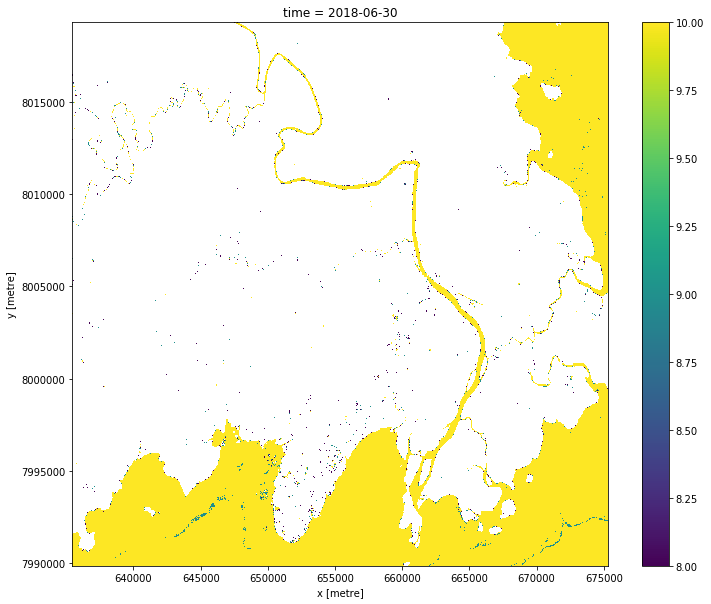

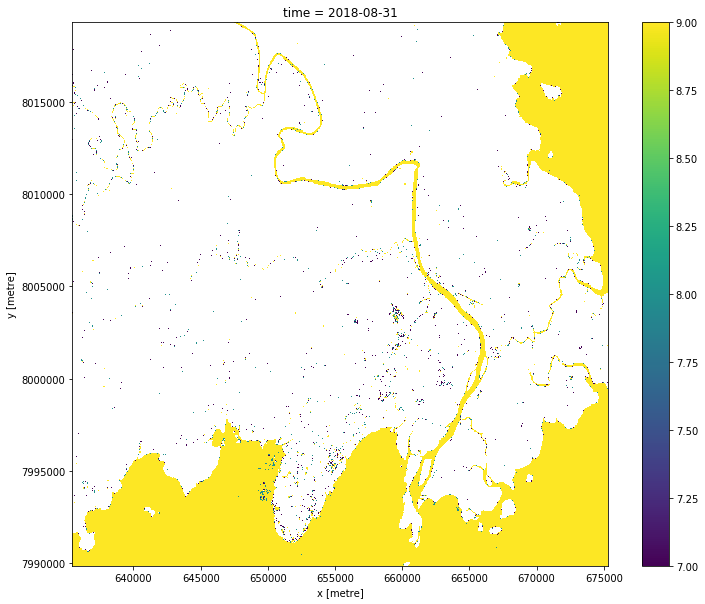

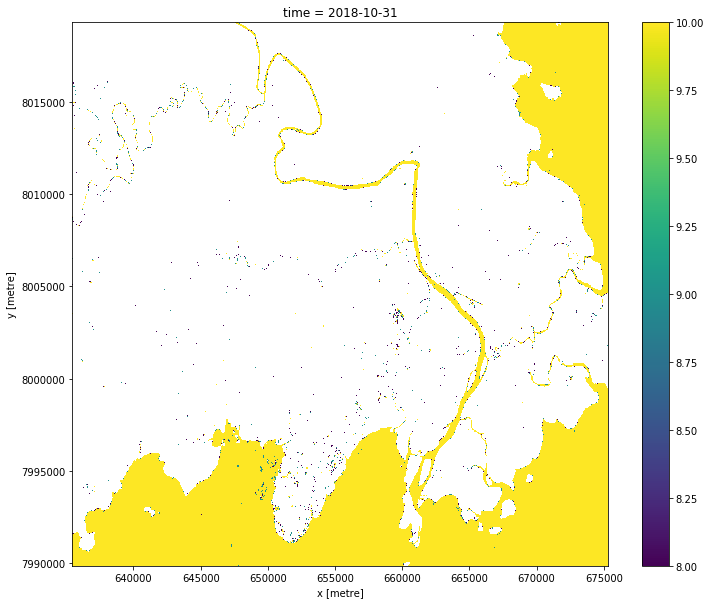

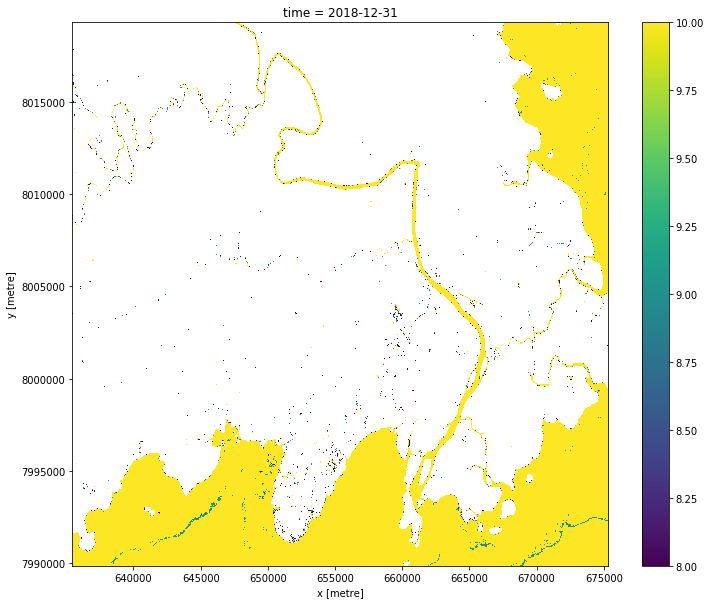

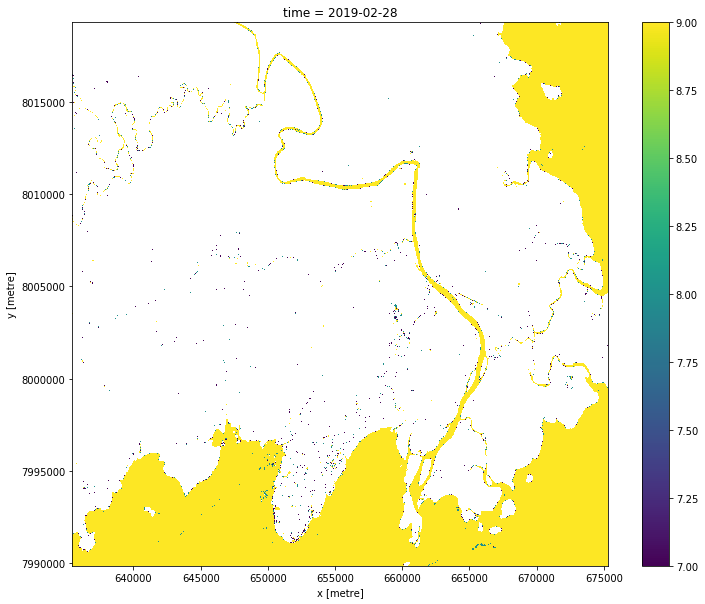

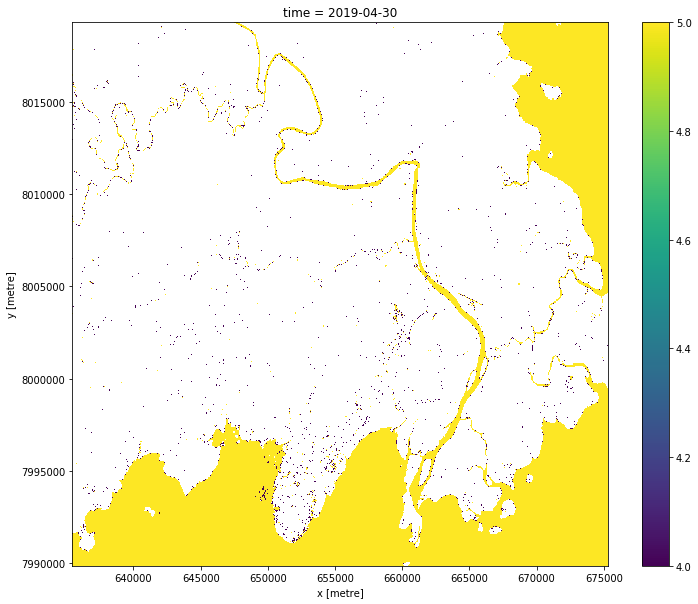

In [52]:
chunks = water.resample(time=time_step).sum('time')
for t in range(0, chunks.time.size):
    layer = chunks.isel(time=t)
    layer_max = layer.max().values
    layer_threshold = (layer_max / 100 ) * threshold
    print(f"{t} t: {layer_threshold} m: {layer_max}")
    print(layer.time.values)
    layer.where(layer > layer_threshold).plot.imshow(figsize=(12,10))
    contour = extract_contour(s1_coverage, layer, layer_threshold, min_vertices)
    save_poly(f"coast_{layer.time.values}.geojson", s1_coverage.crs, contour)


